# 🤖 — Modelagem Baseline

| Informação | Detalhe |
|---|---|
| **Entrada** | `data/processed/char_ngrams/X_*_tfidf.npz`, `tfidf_vectorizer_char_ngrams.joblib`, `train_clean.csv` |
| **Saída** | `models/mlclassico/char-ngrams-baseline/*.joblib`, `reports/baseline_results_char_ngrams.csv` |
| **Notebook anterior** | `2.0-preprocessing.ipynb` |
| **Próximo Notebook** | `3.1-hyperparameter-optimization.ipynb` |

## Objetivo
Estabelecer **baselines** usando representação **Character N-grams (3-5)** com cinco classificadores:

- XGBoost
- Random Forest
- Extra Trees
- Logistic Regression
- LinearSVC
- SGDClassifier

## Pipeline
1. Carregar dados limpos com **Character N-grams** (do notebook `2.0-preprocessing`)
2. Treinar múltiplos classificadores
3. Avaliar com métricas de classificação
4. Comparar resultados e selecionar ensemble diverso

## Dados de entrada
- **Target:** `label` (0 = Real, 1 = Fake)
- **Features:** Character N-grams (3-5) com TF-IDF
- **Vocabulário:** 50k features

> **Nota sobre Character N-grams:** Usamos sequências de 3-5 caracteres. Isso captura padrões em nível de caracteres, tornando o modelo mais robusto a erros ortográficos e capaz de identificar padrões sutis de estilo de escrita.


## 1. Setup

In [25]:
import json
import os
import time
from datetime import datetime
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from xgboost import XGBClassifier
import xgboost as xgb_module
from lime.lime_text import LimeTextExplainer

model_dir = '../models/mlclassico/char-ngrams-baseline'
os.makedirs(model_dir, exist_ok=True)
# Reprodutibilidade
SEED = 42
np.random.seed(SEED)


## 2. Carregar dados vetorizados

In [5]:
PROCESSED_PATH = '../data/processed'
CHAR_NGRAMS_PATH = os.path.join(PROCESSED_PATH, 'char_ngrams')

# Configuração de Cross-Validation
CV_FOLDS = 5

# Carregar matrizes TF-IDF 
print("Carregando dados processados com Character N-grams...")
X_train_tfidf = scipy.sparse.load_npz(os.path.join(CHAR_NGRAMS_PATH, 'X_train_tfidf.npz'))
X_val_tfidf = scipy.sparse.load_npz(os.path.join(CHAR_NGRAMS_PATH, 'X_val_tfidf.npz'))

# Carregar labels
y_train = pd.read_csv(os.path.join(CHAR_NGRAMS_PATH, 'y_train.csv'))['label']
y_val = pd.read_csv(os.path.join(CHAR_NGRAMS_PATH, 'y_val.csv'))['label']

# Carregar vetorizador TF-IDF Character N-grams (para análise de features)
tfidf = joblib.load(os.path.join(CHAR_NGRAMS_PATH, 'tfidf_vectorizer_char_ngrams.joblib'))

# Carregar dados limpos e índices (para análise de erros)
df_clean = pd.read_csv(os.path.join(CHAR_NGRAMS_PATH, 'train_clean.csv'))
df_clean['full_text'] = df_clean['title'].fillna('') + ' ' + df_clean['text'].fillna('')
val_indices = pd.read_csv(os.path.join(CHAR_NGRAMS_PATH, 'val_indices.csv'))['idx'].tolist()

# Reconstruir X_val como Series de textos (para análise de erros)
X_val = df_clean['full_text'].iloc[val_indices].reset_index(drop=True)

print("="*70)
print("✅ DADOS CARREGADOS COM SUCESSO")
print("="*70)
print(f"\n📊 MATRIZES:")
print(f"   X_train_tfidf: {X_train_tfidf.shape[0]:,} × {X_train_tfidf.shape[1]:,} features")
print(f"   X_val_tfidf:   {X_val_tfidf.shape[0]:,} × {X_val_tfidf.shape[1]:,} features")
print("="*70)


Carregando dados processados com Character N-grams...
✅ DADOS CARREGADOS COM SUCESSO

📊 MATRIZES:
   X_train_tfidf: 17,871 × 50,000 features
   X_val_tfidf:   4,468 × 50,000 features


## 3. Baseline 1 — Random Forest

In [7]:
print("Treinando Random Forest...")
t0 = time.time()

rf = RandomForestClassifier(
    random_state=SEED,
    n_jobs=-1
)  
rf.fit(X_train_tfidf, y_train)
rf_time = time.time() - t0

# Predições
y_pred_rf = rf.predict(X_val_tfidf)

# Métricas
rf_f1 = f1_score(y_val, y_pred_rf, average='weighted')
rf_acc = accuracy_score(y_val, y_pred_rf)

print(f"Tempo de treino: {rf_time:.1f}s")
print(f"Accuracy: {rf_acc:.4f}")
print(f"F1 (weighted): {rf_f1:.4f}")
print(f"\n{classification_report(y_val, y_pred_rf, target_names=['Real (0)', 'Fake (1)'])}")

Treinando Random Forest...
Tempo de treino: 6.5s
Accuracy: 0.9996
F1 (weighted): 0.9996

              precision    recall  f1-score   support

    Real (0)       1.00      1.00      1.00      3399
    Fake (1)       1.00      1.00      1.00      1069

    accuracy                           1.00      4468
   macro avg       1.00      1.00      1.00      4468
weighted avg       1.00      1.00      1.00      4468



## 4. Baseline 2 — Extra Trees

In [8]:
# Extra Trees
print("Treinando Extra Trees...")
t0 = time.time()

et = ExtraTreesClassifier(
    random_state=SEED,
    n_jobs=-1,
    n_estimators=100
)
et.fit(X_train_tfidf, y_train)
et_time = time.time() - t0

# Predições
y_pred_et = et.predict(X_val_tfidf)

# Métricas
et_f1 = f1_score(y_val, y_pred_et, average='weighted')
et_acc = accuracy_score(y_val, y_pred_et)

print(f"Tempo de treino: {et_time:.1f}s")
print(f"Accuracy: {et_acc:.4f}")
print(f"F1 (weighted): {et_f1:.4f}")
print(f"\n{classification_report(y_val, y_pred_et, target_names=['Real (0)', 'Fake (1)'])}")

Treinando Extra Trees...
Tempo de treino: 10.5s
Accuracy: 0.9998
F1 (weighted): 0.9998

              precision    recall  f1-score   support

    Real (0)       1.00      1.00      1.00      3399
    Fake (1)       1.00      1.00      1.00      1069

    accuracy                           1.00      4468
   macro avg       1.00      1.00      1.00      4468
weighted avg       1.00      1.00      1.00      4468



## 5. Baseline 3 — Logistic Regression



In [9]:
print("Treinando Logistic Regression...")
t0 = time.time()

lr = LogisticRegression(
    random_state=SEED,
    max_iter=2000
    )
lr.fit(X_train_tfidf, y_train)
lr_time = time.time() - t0

# Predições
y_pred_lr = lr.predict(X_val_tfidf)

# Métricas
lr_f1 = f1_score(y_val, y_pred_lr, average='weighted')
lr_acc = accuracy_score(y_val, y_pred_lr)

print(f"Tempo de treino: {lr_time:.1f}s")
print(f"Accuracy: {lr_acc:.4f}")
print(f"F1 (weighted): {lr_f1:.4f}")
print(f"\n{classification_report(y_val, y_pred_lr, target_names=['Real (0)', 'Fake (1)'])}") 

Treinando Logistic Regression...
Tempo de treino: 3.8s
Accuracy: 0.9917
F1 (weighted): 0.9917

              precision    recall  f1-score   support

    Real (0)       0.99      1.00      0.99      3399
    Fake (1)       1.00      0.97      0.98      1069

    accuracy                           0.99      4468
   macro avg       0.99      0.98      0.99      4468
weighted avg       0.99      0.99      0.99      4468



## 6. Baseline 4 — LinearSVC



In [10]:
print("Treinando LinearSVC...")
t0 = time.time()

svc_base = LinearSVC(
    random_state=SEED,
    max_iter=2000
)
# CalibratedClassifierCV para ter predict_proba 
svc = CalibratedClassifierCV(svc_base, cv=3)
svc.fit(X_train_tfidf, y_train)
svc_time = time.time() - t0

# Predições
y_pred_svc = svc.predict(X_val_tfidf)

# Métricas
svc_f1 = f1_score(y_val, y_pred_svc, average='weighted')
svc_acc = accuracy_score(y_val, y_pred_svc)

print(f"Tempo de treino: {svc_time:.1f}s")
print(f"Accuracy: {svc_acc:.4f}")
print(f"F1 (weighted): {svc_f1:.4f}")
print(f"\n{classification_report(y_val, y_pred_svc, target_names=['Real (0)', 'Fake (1)'])}") 

Treinando LinearSVC...
Tempo de treino: 5.4s
Accuracy: 0.9991
F1 (weighted): 0.9991

              precision    recall  f1-score   support

    Real (0)       1.00      1.00      1.00      3399
    Fake (1)       1.00      1.00      1.00      1069

    accuracy                           1.00      4468
   macro avg       1.00      1.00      1.00      4468
weighted avg       1.00      1.00      1.00      4468



## 7. Baseline 5 — SGDClassifier



In [11]:
print("Treinando SGDClassifier...")
t0 = time.time()

sgd = SGDClassifier(
    random_state=SEED,
    n_jobs=-1
)  
sgd.fit(X_train_tfidf, y_train)
sgd_time = time.time() - t0

# Predições
y_pred_sgd = sgd.predict(X_val_tfidf)

# Métricas
sgd_f1 = f1_score(y_val, y_pred_sgd, average='weighted')
sgd_acc = accuracy_score(y_val, y_pred_sgd)

print(f"Tempo de treino: {sgd_time:.1f}s")
print(f"Accuracy: {sgd_acc:.4f}")
print(f"F1 (weighted): {sgd_f1:.4f}")
print(f"\n{classification_report(y_val, y_pred_sgd, target_names=['Real (0)', 'Fake (1)'])}")

Treinando SGDClassifier...
Tempo de treino: 0.7s
Accuracy: 0.9989
F1 (weighted): 0.9989

              precision    recall  f1-score   support

    Real (0)       1.00      1.00      1.00      3399
    Fake (1)       1.00      1.00      1.00      1069

    accuracy                           1.00      4468
   macro avg       1.00      1.00      1.00      4468
weighted avg       1.00      1.00      1.00      4468



## 8. Baseline 6 — XGBoost


In [12]:
print("Treinando XGBoost...")
t0 = time.time()

xgb = XGBClassifier(
    random_state=SEED,
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    eval_metric="logloss",
    early_stopping_rounds=10 
)

xgb.fit(
    X_train_tfidf,
    y_train,
    eval_set=[(X_val_tfidf, y_val)],
    verbose=False
)

xgb_time = time.time() - t0
y_pred_xgb = xgb.predict(X_val_tfidf)
xgb_f1 = f1_score(y_val, y_pred_xgb, average="weighted")
xgb_acc = accuracy_score(y_val, y_pred_xgb)

print(f"Tempo de treino: {xgb_time:.1f}s")
print(f"Accuracy: {xgb_acc:.4f}")
print(f"F1 (weighted): {xgb_f1:.4f}")
print(f"\n{classification_report(y_val, y_pred_xgb, target_names=['Real (0)', 'Fake (1)'])}")



Treinando XGBoost...
Tempo de treino: 756.7s
Accuracy: 1.0000
F1 (weighted): 1.0000

              precision    recall  f1-score   support

    Real (0)       1.00      1.00      1.00      3399
    Fake (1)       1.00      1.00      1.00      1069

    accuracy                           1.00      4468
   macro avg       1.00      1.00      1.00      4468
weighted avg       1.00      1.00      1.00      4468



## 9. Comparação dos modelos

In [13]:
# --- Tabela comparativa ---
all_preds = {
    'Random Forest': y_pred_rf,
    'Extra Trees': y_pred_et,
    'Logistic Regression': y_pred_lr,
    'LinearSVC': y_pred_svc,
    'SGDClassifier': y_pred_sgd,
    'XGBoost': y_pred_xgb,
}

all_times = [rf_time, et_time, lr_time, svc_time, sgd_time, xgb_time]
all_f1    = [rf_f1,   et_f1,   lr_f1,   svc_f1,   sgd_f1,   xgb_f1]
all_acc   = [rf_acc,  et_acc,  lr_acc,  svc_acc,  sgd_acc,  xgb_acc]

results = pd.DataFrame({
    'Modelo': list(all_preds.keys()),
    'Accuracy': all_acc,
    'F1 (weighted)': all_f1,
    'Precision': [precision_score(y_val, pred, average='weighted') for pred in all_preds.values()],
    'Recall': [recall_score(y_val, pred, average='weighted') for pred in all_preds.values()],
    'Tempo (s)': all_times
})

results = results.sort_values('F1 (weighted)', ascending=False).reset_index(drop=True)

print("=" * 80)
print(f"COMPARAÇÃO — TODOS OS BASELINES CHARACTER N-GRAMS ({len(all_preds)} modelos)")
print("=" * 80)
print(results.to_string(index=False, float_format='%.4f'))

best_idx = results['F1 (weighted)'].idxmax()
best_model_name = results.loc[best_idx, 'Modelo']
print(f"\n🏆 Melhor baseline: {best_model_name} "
      f"com F1 = {results.loc[best_idx, 'F1 (weighted)']:.4f}")


COMPARAÇÃO — TODOS OS BASELINES CHARACTER N-GRAMS (6 modelos)
             Modelo  Accuracy  F1 (weighted)  Precision  Recall  Tempo (s)
            XGBoost    1.0000         1.0000     1.0000  1.0000   756.6586
        Extra Trees    0.9998         0.9998     0.9998  0.9998    10.5169
      Random Forest    0.9996         0.9996     0.9996  0.9996     6.4601
          LinearSVC    0.9991         0.9991     0.9991  0.9991     5.3772
      SGDClassifier    0.9989         0.9989     0.9989  0.9989     0.6729
Logistic Regression    0.9917         0.9917     0.9918  0.9917     3.7619

🏆 Melhor baseline: XGBoost com F1 = 1.0000


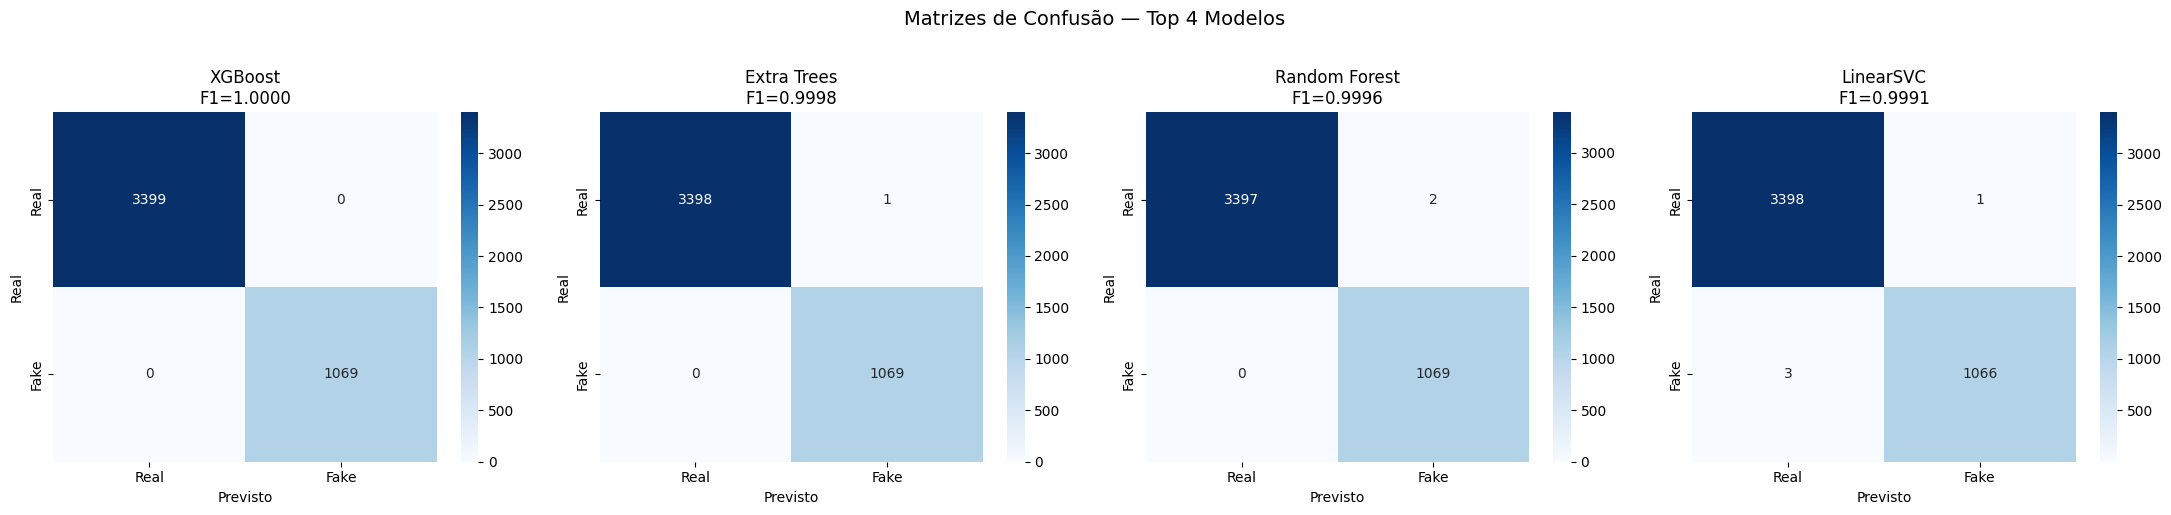

In [14]:
# --- Matrizes de confusão (top 4 melhores modelos) ---
top4_models = results.head(4)['Modelo'].tolist()

fig, axes = plt.subplots(1, 4, figsize=(22, 5))

for ax, name in zip(axes, top4_models):
    y_pred = all_preds[name]
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    f1 = f1_score(y_val, y_pred, average='weighted')
    ax.set_title(f'{name}\nF1={f1:.4f}')
    ax.set_ylabel('Real')
    ax.set_xlabel('Previsto')

plt.suptitle('Matrizes de Confusão — Top 4 Modelos', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 10. Análise de Concordância/Discordância entre Modelos

In [15]:
# Criar matriz de predições (amostras x modelos)
pred_matrix = np.column_stack(list(all_preds.values()))
model_names = list(all_preds.keys())

# Contar votos para classe 1 (Fake) em cada amostra
votes_for_fake = pred_matrix.sum(axis=1)

# Classificar concordância
n_models = len(model_names)
print("=" * 70)
print("ANÁLISE DE CONCORDÂNCIA ENTRE MODELOS")
print("=" * 70)

print(f"\nDistribuição de votos para Fake (de 0 a {n_models}):")
for v in range(n_models + 1):
    count = (votes_for_fake == v).sum()
    pct = count / len(votes_for_fake) * 100
    label = y_val.iloc[votes_for_fake == v] if count > 0 else []
    acc = (label == (1 if v > n_models // 2 else 0)).mean() * 100 if len(label) > 0 else 0
    bar = "█" * int(pct / 2)
    print(f"  {v} votos: {count:5,} ({pct:5.1f}%) {bar}")

# Concordância total (todos concordam)
all_agree = ((votes_for_fake == 0) | (votes_for_fake == n_models)).sum()
print(f"\n📊 Concordância total ({n_models}/{n_models}): {all_agree:,} de {len(votes_for_fake):,} ({all_agree/len(votes_for_fake)*100:.1f}%)")

ANÁLISE DE CONCORDÂNCIA ENTRE MODELOS

Distribuição de votos para Fake (de 0 a 6):
  0 votos: 3,396 ( 76.0%) ██████████████████████████████████████
  1 votos:     1 (  0.0%) 
  2 votos:     1 (  0.0%) 
  3 votos:     4 (  0.1%) 
  4 votos:     1 (  0.0%) 
  5 votos:    32 (  0.7%) 
  6 votos: 1,033 ( 23.1%) ███████████

📊 Concordância total (6/6): 4,429 de 4,468 (99.1%)


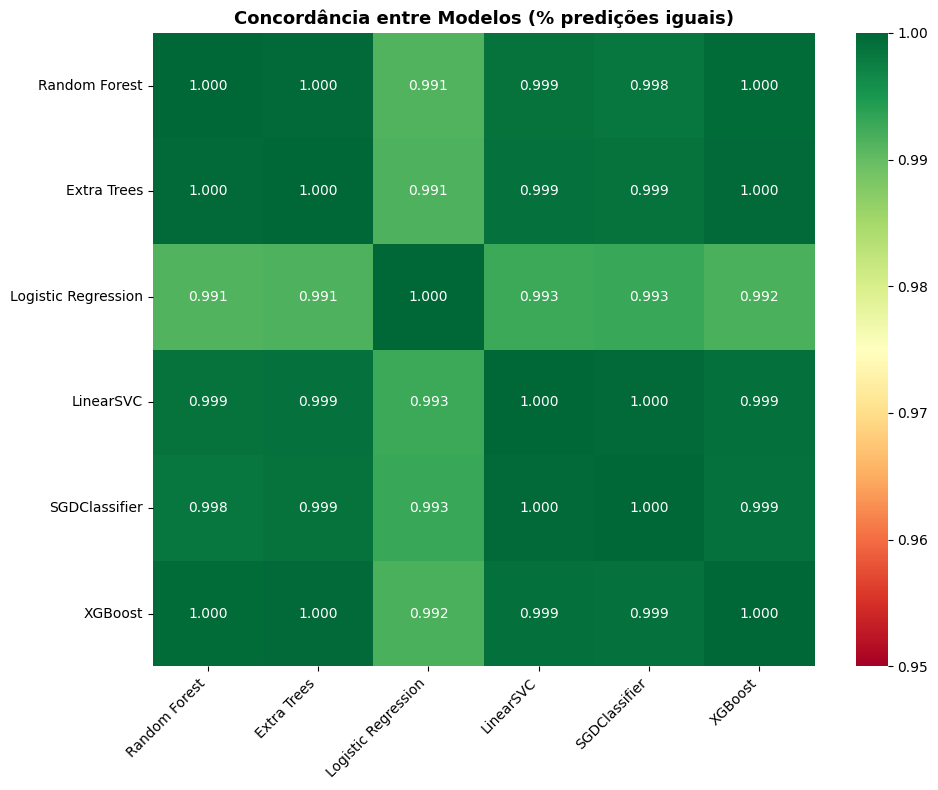

In [17]:
# Matriz de concordância par-a-par entre modelos
agreement_matrix = np.zeros((n_models, n_models))

for i in range(n_models):
    for j in range(n_models):
        agreement_matrix[i, j] = (pred_matrix[:, i] == pred_matrix[:, j]).mean()

# Visualizar
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(agreement_matrix, annot=True, fmt='.3f', cmap='RdYlGn', 
            xticklabels=model_names, yticklabels=model_names, ax=ax,
            vmin=0.95, vmax=1.0)
ax.set_title('Concordância entre Modelos (% predições iguais)', fontweight='bold', fontsize=13)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()


## 11. Top features 

Quais sequências de caracteres (3-5 chars) o modelo considerou mais relevantes para cada classe?

**Nota:** Com Character N-grams, as features são sequências de caracteres, não palavras completas. 
Isso permite capturar padrões como:
- Sufixos/prefixos comuns
- Fragmentos de URLs
- Padrões de pontuação
- Estilo de escrita

Total de features (char n-grams): 50,000
Exemplos de features: [' $1', ' $1 ', ' $1.', ' $10', ' $100', ' $15', ' $2', ' $20', ' $3', ' $4']


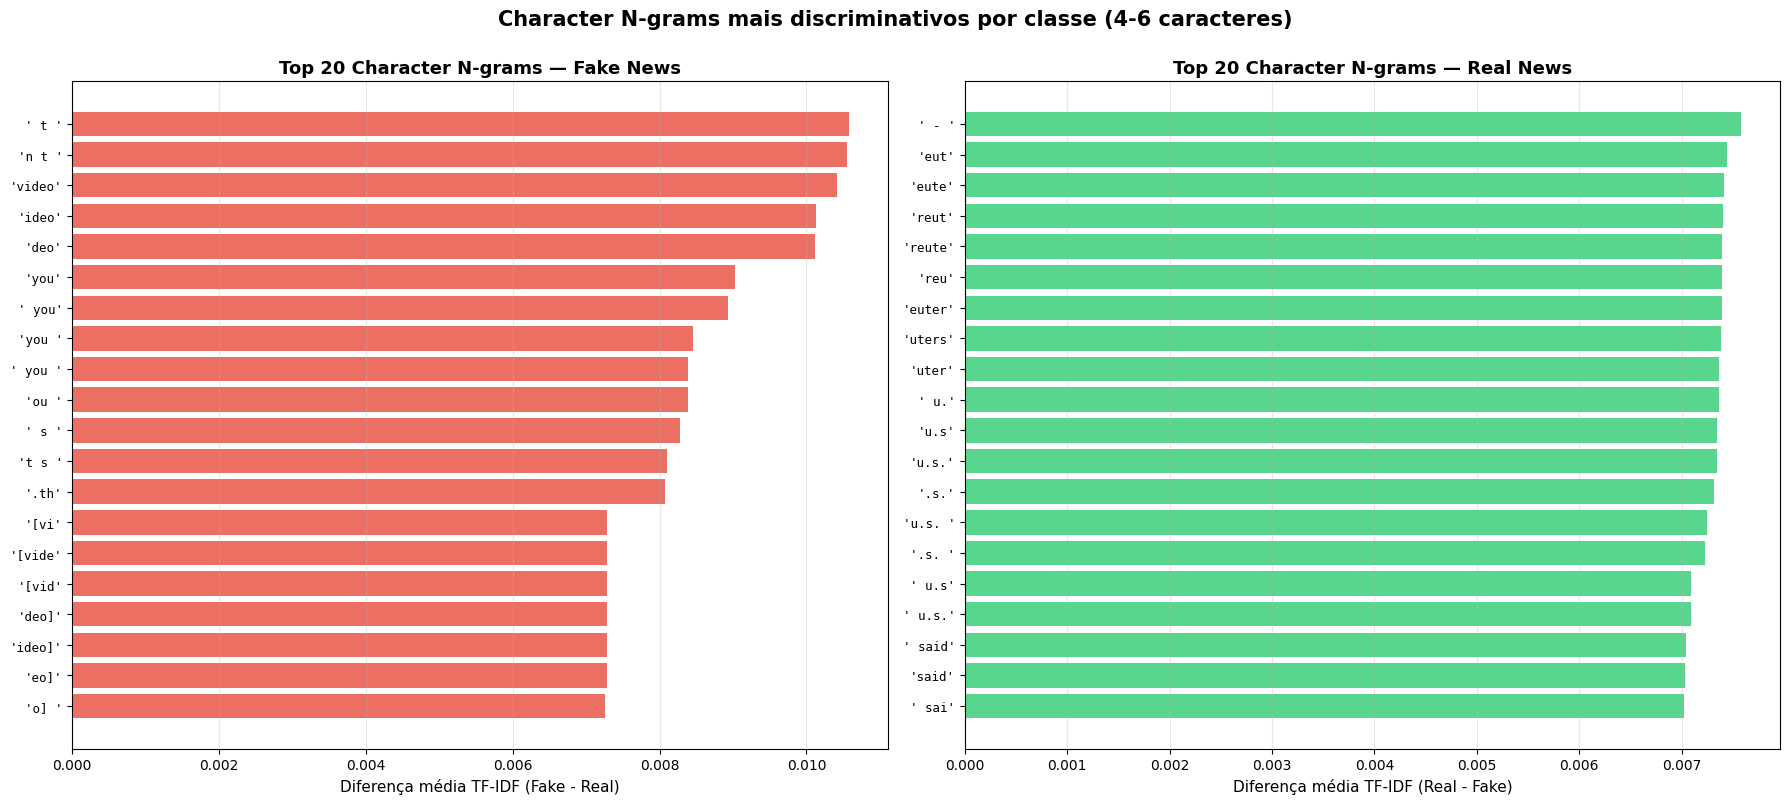

In [21]:
# Média de TF-IDF por classe
feature_names = tfidf.get_feature_names_out()

print(f"Total de features (char n-grams): {len(feature_names):,}")
print(f"Exemplos de features: {list(feature_names[:10])}")

# Calcular média TF-IDF para cada classe
# Converter para numpy array para compatibilidade com matriz sparse
real_mask = (y_train == 0).values if hasattr(y_train, 'values') else (y_train == 0)
fake_mask = (y_train == 1).values if hasattr(y_train, 'values') else (y_train == 1)

mean_tfidf_real = X_train_tfidf[real_mask].mean(axis=0).A1
mean_tfidf_fake = X_train_tfidf[fake_mask].mean(axis=0).A1

# Diferença: positivo = mais frequente em Fake, negativo = mais frequente em Real
diff = mean_tfidf_fake - mean_tfidf_real

top_n = 20  # Mais features para char n-grams
top_fake_idx = diff.argsort()[-top_n:][::-1]
top_real_idx = diff.argsort()[:top_n]

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Top Fake
axes[0].barh(range(top_n), diff[top_fake_idx], color='#e74c3c', alpha=0.8)
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels([f"'{fn}'" for fn in feature_names[top_fake_idx]], fontsize=9, family='monospace')
axes[0].set_title(f'Top {top_n} Character N-grams — Fake News', fontweight='bold', fontsize=13)
axes[0].set_xlabel('Diferença média TF-IDF (Fake - Real)', fontsize=11)
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Top Real
axes[1].barh(range(top_n), abs(diff[top_real_idx]), color='#2ecc71', alpha=0.8)
axes[1].set_yticks(range(top_n))
axes[1].set_yticklabels([f"'{fn}'" for fn in feature_names[top_real_idx]], fontsize=9, family='monospace')
axes[1].set_title(f'Top {top_n} Character N-grams — Real News', fontweight='bold', fontsize=13)
axes[1].set_xlabel('Diferença média TF-IDF (Real - Fake)', fontsize=11)
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.suptitle('Character N-grams mais discriminativos por classe (4-6 caracteres)', 
             fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('../reports/figures/char_ngrams_top_features.png', dpi=300, bbox_inches='tight')
plt.show()

## 12. Salvar modelos


In [27]:
# Mapeamento nome → objeto do modelo
model_map = {
    'Random Forest': rf,
    'Extra Trees': et,
    'Logistic Regression': lr,
    'LinearSVC': svc,
    'SGDClassifier': sgd,
    'XGBoost': xgb,
}

print("=" * 70)
print("💾 SALVANDO TODOS OS MODELOS BASELINE")
print("=" * 70)

for rank, row in results.iterrows():
    model_name = row['Modelo']
    model_obj = model_map[model_name]

    filename = f"model_{rank+1}_{model_name.lower().replace(' ', '_')}.joblib"
    filepath = os.path.join(model_dir, filename)

    joblib.dump(model_obj, filepath)

    print(f"✓ [{rank+1}] {model_name:20s} → {filename}")
    print(f"    Val Accuracy: {row['Accuracy']:.6f} | Val F1: {row['F1 (weighted)']:.6f}")



💾 SALVANDO TODOS OS MODELOS BASELINE
✓ [1] XGBoost              → model_1_xgboost.joblib
    Val Accuracy: 1.000000 | Val F1: 1.000000
✓ [2] Extra Trees          → model_2_extra_trees.joblib
    Val Accuracy: 0.999776 | Val F1: 0.999776
✓ [3] Random Forest        → model_3_random_forest.joblib
    Val Accuracy: 0.999552 | Val F1: 0.999553
✓ [4] LinearSVC            → model_4_linearsvc.joblib
    Val Accuracy: 0.999105 | Val F1: 0.999104
✓ [5] SGDClassifier        → model_5_sgdclassifier.joblib
    Val Accuracy: 0.998881 | Val F1: 0.998880
✓ [6] Logistic Regression  → model_6_logistic_regression.joblib
    Val Accuracy: 0.991719 | Val F1: 0.991671
